# Import Relevant Credentials and Packages

In [30]:
from config import database,user,password,server
from joblib import dump,load
import pymssql
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef

# Connect to SQL Server to make the data

In [4]:
conn = pymssql.connect(server,user,password,database)
query1 = "SELECT BusinessID,Stars FROM dbo.Business"
df1 = pd.read_sql(query1,conn)

d:\Python\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
query2 = "SELECT * FROM dbo.MachineLearning"
df2 = pd.read_sql(query2,conn)

d:\Python\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [6]:
df = df1.merge(df2,on='BusinessID',how='inner')
df = df.drop_duplicates()
df.drop('BusinessID',inplace=True,axis=1)

# Convert Categorical Variables into Numeric

In [7]:
replace = list(df['Alcohol'].unique())
replace

['none', None, 'beer_and_wine', 'full_bar']

In [8]:
df.replace(replace,['0',np.nan,'1','2'],inplace=True)

In [9]:
replace = list(df['NoiseLevel'].unique())
replace.remove(np.nan)
replace

['average', 'quiet', 'loud', 'very_loud']

In [10]:
df.replace(replace,['1','0','2','3'],inplace=True)

In [11]:
replace = list(df['RestaurantsAttire'].unique())
replace.remove(np.nan)
replace

['casual', 'dressy', 'formal']

In [12]:
df.replace(replace,['0','1','2'],inplace=True)

In [13]:
replace = list(df['WiFi'].unique())
replace.remove(np.nan)
replace

['no', 'free', 'paid']

In [14]:
df.replace(replace,['0','2','1'],inplace=True)

In [15]:
for i in df.columns:
    df[i] = pd.to_numeric(df[i])

In [18]:
df['Stars'] = df['Stars'].astype(int)

# Machine Learning Process

In [20]:
# Split the dependent and independent variables
X = df.copy()
X.drop('Stars',axis=1,inplace=True)
y = df['Stars'].copy()

In [21]:
# Standardize th independent variables (model tuning)
sc = StandardScaler()
X_trans = pd.DataFrame(sc.fit_transform(X),index=X.index,columns=X.columns)

In [22]:
# Split the test dataset and the train dataset
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size = 0.25,random_state = 61)

# Use Grid Search for Parameter Tuning

In [25]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [36]:
estimator = xgb.XGBClassifier(
    objective = 'multi:softmax',
    num_class = 5,
    nthread=4,
    seed =61,
    missing = np.nan
)

parameters = {
    'max_depth': [3,5],
    'n_estimators': [100,140,180],
    'learning_rate': [0.1, 0.3, 0.05],
    'min_child_weight':[1,3]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring='f1_micro',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

In [37]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_class=5, num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.3, 0.05], 'max_depth': [3, 5],
                         'min_child_weight': [1, 3],
                         'n_estimators': [100, 140, 180]},
             scoring='f1_micro', verbose=True)

In [38]:
print(grid_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=140,
              n_jobs=4, nthread=4, num_class=5, num_parallel_tree=1,
              objective='multi:softmax', predictor='auto', ...)


# Write the optimal model

In [40]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', 
              learning_rate=0.1, max_depth=5, min_child_weight=3,
              missing=np.nan, n_estimators=140,
              n_jobs=4, nthread=4, num_class=5,
              objective='multi:softmax', predictor='auto')

In [41]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=140,
              n_jobs=4, nthread=4, num_class=5, num_parallel_tree=1,
              objective='multi:softmax', predictor='auto', ...)

In [42]:
y_predicted = clf.predict(X_test)

In [43]:
print(matthews_corrcoef(y_test,y_predicted))

0.26521161485948486


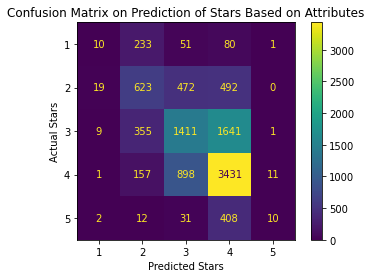

In [44]:
labels = [1,2,3,4,5]
ticks = [0,1,2,3,4]
cm = confusion_matrix(y_test,y_predicted)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.xlabel('Predicted Stars')
plt.ylabel('Actual Stars')
plt.xticks(ticks,labels)
plt.yticks(ticks,labels)
plt.title('Confusion Matrix on Prediction of Stars Based on Attributes')
plt.show()

The Matthew Correlation Coefficient is 0.265, which is relatively low. It means that for most of the predictions, the predicted stars if not the same as the actual stars, which means that a business' rating can not be predicted purely bsaed on the business attributes. A possible explanation could be that the data source converted some of the numeric variables (average price, loudness by average dB) to categorical variables(pricerange, and loudness in categories), which loses some accuracy. 

# Export the optimal model

In [46]:
dump(clf,'Capstone_MachineLearning.model')

['Capstone_MachineLearning.model']